# การทำนายกลุ่มของวัตถุ โดยใช้ Custom Detection Model

ในกระบวนการพัฒนาเครื่องมือการทำนายท่าทางการยกมือ จะมีขั้นตอนเริ่มต้นจากการกำหนดจุดสำคัญต่าง ๆ ในร่างกาย ซึ่งจากโมเดลที่พัฒนาโดย Mediapipe บวกกับเลเยอร์เพิ่มเติมที่ผู้ใช้งานเขียนขึ้น ทำให้เราสามารถกำหนดกลุ่มของวัตถุที่ต้องการแยกได้จำนวน 4 กลุ่ม เพื่อใช้ในการทำนายกลุ่มของวัตถุ ซึ่งการกำหนดกลุ่มเหล่านี้ ได้รับการพัฒนามาจากการเรียนรู้ภาพต้นแบบในแต่ละกลุ่ม ทำให้ได้จุดที่สำคัญและสรุปออกมาเป็นชื่อกลุ่มที่มีค่าความเชื่อมั่น (score) สูงที่สุด ดังรูป
<br><br>
![custom_landmarks.png](https://raw.github.com/hengkp/mediapipe_examples/main/landmarks/custom_landmarks.png)<br><br>

ซึ่งเครื่องมือจากโมเดลดังกล่าวนี้ สามารถทำนาย กลุ่มของวัตถุได้เป็น 4 กลุ่มตามโฟลเดอร์ ได้แก่ apple, keyboard, scissor, และ umbrella โดยแต่ละกลุ่มที่ทำนายได้ จะมีการประมวลผลข้อมูลจากจุดและพิกัดบนรูปภาพเพื่อหาลักษณะเฉพาะและสรุปผลออกมาเป็นหมายเลขกลุ่มพร้อมค่าความเชื่อมั่น (score) กล่าวคือ

ในการเรียนรู้วัตถุต่างๆจะถูกแบ่งเป็น 4 กลุ่มตามโฟลเดอร์ ได้แก่ apple, keyboard, scissor, และ umbrella โดยตัวอย่างแต่ละกลุ่ม จะมีจำนวนรูปภาพ เท่ากับ 3 ภาพ เพื่อใช้ในการเรียนรู้ และทำการทำนายภาพว่าอยู่ในกลุ่มใดต่อไป

ซึ่งขั้นตอนการนำภาพถ่ายมาผ่านโปรแกรมทำนายกลุ่มของวัตถุในรูปภาพได้สรุปเอาไว้ 9 ขั้นตอน ดังนี้
<br><br>
![custom_workflow.jpg](https://raw.github.com/hengkp/mediapipe_examples/main/workflows/custom_workflow.jpg)
<br><br>

โดยมีรายละเอียดพร้อมตัวอย่างโค้ดในขั้นตอนต่าง ๆ คือ<br>
**ขั้นตอนที่ 1** การนำเข้าและเตรียมโมเดล<br>
**ขั้นตอนที่ 2** การเตรียมชุดรูปภาพสำหรับเทรนโมเดล<br>
**ขั้นตอนที่ 3** เทรนโมเดลด้วยชุดรูปภาพที่เตรียมไว้<br>
**ขั้นตอนที่ 4** นำเข้าภาพ<br>
**ขั้นตอนที่ 5** ปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล<br>
**ขั้นตอนที่ 6** ประมวลผลรูปผ่านโมเดล<br>
**ขั้นตอนที่ 7** ดึงข้อมูลที่ได้จากผลการประมวล<br>
**ขั้นตอนที่ 8** แสดงผลรูปการตำแหน่งของวัตถุ<br>
**ขั้นตอนที่ 9** แสดงผลค่าการทำนายตำแหน่งของวัตถุ<br>

In [1]:
#@title **ขั้นตอนที่ 1** การนำเข้าและเตรียมโมเดล

import os
import tensorflow as tf

# กำหนดจำนวนกลุ่มตัวอย่างที่ต้องการแยก
num_classes = 4

# กำหนดจำนวนตัวอย่างของแต่ละกลุ่ม
num_samples_train = 3

# กำหนดขนาดของภาพ
IMG_HEIGHT = 224
IMG_WIDTH = 224

# เตรียมโมเดลพื้นฐาน
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# ตั้งค่าโมเดลพื้นฐานไม่ให้สามารถเปลี่ยนแปลงได้
for layer in base_model.layers:
    layer.trainable = False

# ปรับแต่งโมเดลโดยเพิ่มขั้นตอนการแยกกลุ่ม เพื่อให้ได้ผลลัพท์ตามจำนวนที่กำหนด
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# กำหนดค่าฟังก์ชั่นที่จำเป็นต่อการเทรนโมเดล
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [2]:
#@title **ขั้นตอนที่ 2** การเตรียมชุดรูปภาพสำหรับเทรนโมเดล

import os

# ดึงตัวอย่างภาพที่ต้องการจาก Github
!rm -rf mediapipe_examples && git clone --quiet -b main --single-branch https://github.com/hengkp/mediapipe_examples.git mediapipe_examples

# ใส่ที่อยู่ของภาพที่ต้องการเทรนโมเดล
train_path = "/content/mediapipe_examples/datasets/train_images"

# กำหนดชื่อของแต่ละกลุ่ม
class_names = ['apple', 'keyboard', 'scissor', 'umbrella']

# เตรียมชุดข้อมูล
data_gen = tf.keras.preprocessing.image.ImageDataGenerator()

# นำภาพที่ต้องการมาใส่ในชุดข้อมูลที่เตรียมไว้
train_dataset = data_gen.flow_from_directory(directory=train_path, 
                                             target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                             batch_size=num_samples_train, 
                                             class_mode='categorical', 
                                             classes=class_names)

train_dataset

Found 12 images belonging to 4 classes.


In [3]:
#@title **ขั้นตอนที่ 3** เทรนโมเดล

history = model.fit(train_dataset, 
                    epochs=5, 
                    steps_per_epoch=len(train_dataset),
                    verbose=2)

# บันทึกโมเดลที่ผ่านการเทรนแล้ว
model.save('custom_model.h5')

Epoch 1/5
4/4 - 18s - loss: 1.6363 - accuracy: 0.4167 - 18s/epoch - 4s/step
Epoch 2/5
4/4 - 1s - loss: 0.7721 - accuracy: 0.7500 - 1s/epoch - 279ms/step
Epoch 3/5
4/4 - 1s - loss: 0.4507 - accuracy: 1.0000 - 882ms/epoch - 221ms/step
Epoch 4/5
4/4 - 1s - loss: 0.2780 - accuracy: 1.0000 - 522ms/epoch - 130ms/step
Epoch 5/5
4/4 - 0s - loss: 0.1740 - accuracy: 1.0000 - 475ms/epoch - 119ms/step


In [4]:
#@title **ขั้นตอนเสริม** การนำเข้าโมเดลที่เก็บไว้ในโฟลเดอร์

model = tf.keras.models.load_model('custom_model.h5')

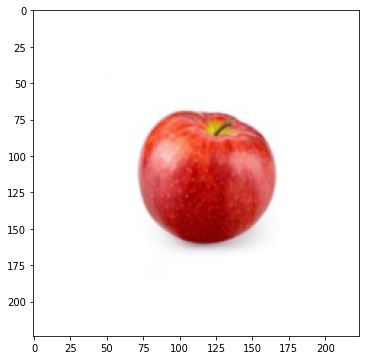

In [5]:
#@title **ขั้นตอนที่ 4-5** นำเข้าและปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io

# ใส่ที่อยู่ของภาพที่ต้องการนำเข้า
image_path = "https://raw.github.com/hengkp/mediapipe_examples/main/datasets/train_images/apple/04.jpg"

# ขั้นตอนที่ 4 นำเข้าภาพ
img = io.imread(image_path)

# ขั้นตอนที่ 5 ปรับขนาดภาพให้สอดคล้องกับความต้องการของโมเดล
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # resize to match inputs of model

# แสดงตัวอย่างภาพ
fig = plt.figure(figsize=(6, 6)) # define size of figure
plt.imshow(img) # display image in the figure
plt.show()

In [6]:
#@title **ขั้นตอนที่ 6-7** ประมวลผลรูปผ่านโมเดลเพื่อทำนายกลุ่มของตัวอย่าง

import numpy as np

# ขั้นตอนที่ 6 ประมวลผลภาพ
prediction = model.predict(np.expand_dims(img, axis=0), verbose=0)

# ขั้นตอนที่ 7 ดึงข้อมูลพิกัดที่สำคัญที่ได้จากผลการประมวล
class_index = np.argmax(prediction[0])
class_name = list(class_names)[class_index]

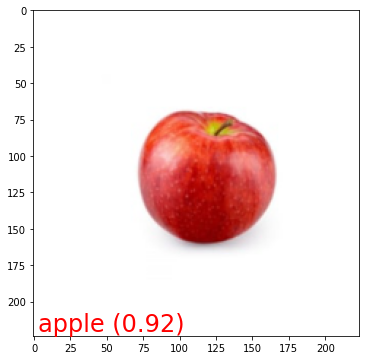

In [7]:
#@title **ขั้นตอนที่ 8** แสดงผลรูปตำแหน่งของวัตถุ

from matplotlib import pyplot as plt
import numpy as np

# เตรียมรูปภาพเพื่อแสดงผล
if np.max(img) <= 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(6, 6)) # define size of figure

# ใส่รูปภาพ
plt.imshow(img)

# ใส่ชื่อวัตถุลงในภาพ
text = class_name + " ({:.2f})".format(prediction[0][class_index])
ax.annotate(text, (3, 220), fontsize=24, color="red")

# แสดงผลรูปภาพพร้อมพิกัด
plt.show()

In [8]:
#@title **ขั้นตอนที่ 9** แสดงผลตำแหน่งของวัตถุ

# แสดงผลชื่อกลุ่มของวัตถุนั้น
text = class_name + " ({:.2f})".format(prediction[0][class_index])
print("Predicted Class:", text)

Predicted Class: apple (0.92)
